# Produce geometrical XY map

<i>
This notebook takes a clean kDST and a correction file,
performs the lifetime correction and measures the energy
at different points of the XY plane. The resulting map
is stored in the same correction file.
</i>

### Notebook configuration

In [7]:
run_number          = 5812
input_dst_filename  = f"$IC_DATA/RunIV/kdst_{run_number}_v0.9.6-29-g2ec1284_20180607_kr_dev_filtered.h5"
correction_filename = f"$IC_DATA/XYmaps/corrections_run{run_number}.h5"
plots_output_folder = f"plots/{run_number}/"
overwrite           = True

XYrange = -200,  200
XYnbins = 100

# Plotting style
default_cmap = "viridis"
figure_size  = 16, 12
font_size    = 15

save_plots   = True
with_titles  = False
plots_format = "pdf"

### Imports

In [8]:
import os
import time
import collections
import warnings

import tables            as tb
import numpy             as np
import matplotlib.pyplot as plt

import invisible_cities.core.fit_functions as fitf
import invisible_cities.reco.dst_functions as dstf
import invisible_cities.io  .kdst_io       as kdstio

from invisible_cities.core .core_functions import in_range
from invisible_cities.core .stat_functions import poisson_sigma
from invisible_cities.icaro. hst_functions import hist
from invisible_cities.icaro. hst_functions import display_matrix
from invisible_cities.icaro. hst_functions import shift_to_bin_centers
from invisible_cities.icaro. hst_functions import plot_writer

from icaro.core.fit_functions import gauss_seed
from icaro.core.fit_functions import relative_errors
from icaro.core.fit_functions import conditional_labels
from icaro.core.fit_functions import fit_slices_2d_profile

labels = conditional_labels(with_titles)
save   = plot_writer(plots_output_folder, plots_format) if save_plots else lambda *x: None

%matplotlib inline

In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Initialization

In [10]:
XYbins    = np.linspace(*XYrange, XYnbins + 1)
XYcenters = shift_to_bin_centers(XYbins)
XYpitch   = np.diff(XYbins)[0]

input_dst_filename   = os.path.expandvars( input_dst_filename)
correction_filename  = os.path.expandvars(correction_filename)

plt.rcParams["figure.figsize"] = figure_size
plt.rcParams[  "font.size"   ] =   font_size

warnings.filterwarnings('ignore', category=tb.NaturalNameWarning)

### Read data

In [11]:
dst           = dstf.load_dst(input_dst_filename, "DST", "Events")
unique_events = ~dst.event.duplicated()

number_of_S2s_full  = np.size         (unique_events)
number_of_evts_full = np.count_nonzero(unique_events)

print(f"Total number of S2s   : {number_of_S2s_full} ")
print(f"Total number of events: {number_of_evts_full}")

Total number of S2s   : 1207442 
Total number of events: 1189019


In [12]:
ELT_correction  = dstf.load_lifetime_xy_corrections(correction_filename,
                                                    group = "XYcorrections",
                                                    node  = "Elifetime")

QLT_correction  = dstf.load_lifetime_xy_corrections(correction_filename,
                                                    group = "XYcorrections",
                                                    node  = "Qlifetime")

EGEO_correction = dstf.load_xy_corrections(correction_filename,
                                           group         = "XYcorrections",
                                           node          = "Egeometry",
                                           norm_strategy = "index",
                                           norm_opts     ={"index": (40, 40)})

QGEO_correction = dstf.load_xy_corrections(correction_filename,
                                           group         = "XYcorrections",
                                           node          = "Qgeometry",
                                           norm_strategy = "index",
                                           norm_opts     ={"index": (40, 40)})

In [13]:
X = dst.X   .values
Y = dst.Y   .values
Z = dst.Z   .values
E = dst.S2e .values * ELT_correction(Z, X, Y).value * EGEO_correction(X, Y).value
Q = dst.S2q .values * QLT_correction(Z, X, Y).value * QGEO_correction(X, Y).value
T = dst.time.values

### Event distribution

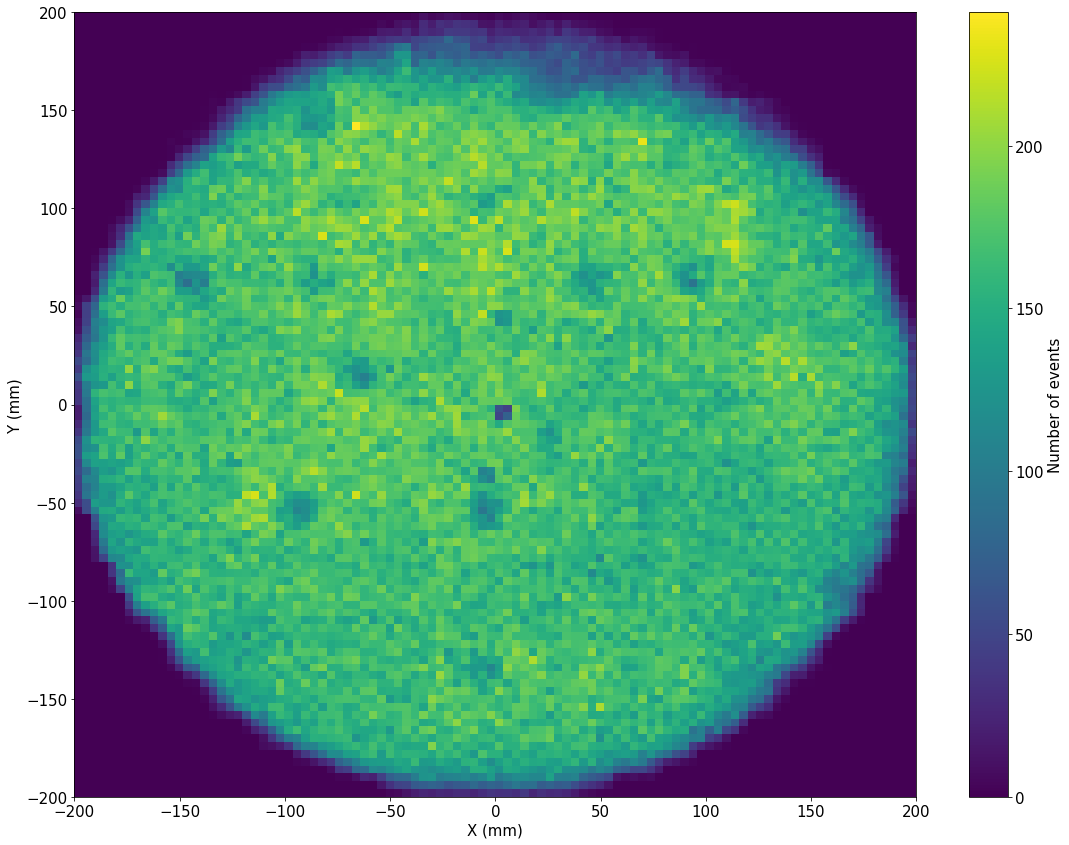

In [14]:
Nevt, *_ = plt.hist2d(X, Y, (XYbins, XYbins))
plt.colorbar().set_label("Number of events")
labels("X (mm)", "Y (mm)", f"Event distribution for {XYpitch:.1f} mm pitch")

plt.tight_layout()
save("Event_distribution_different_pitches_XY")

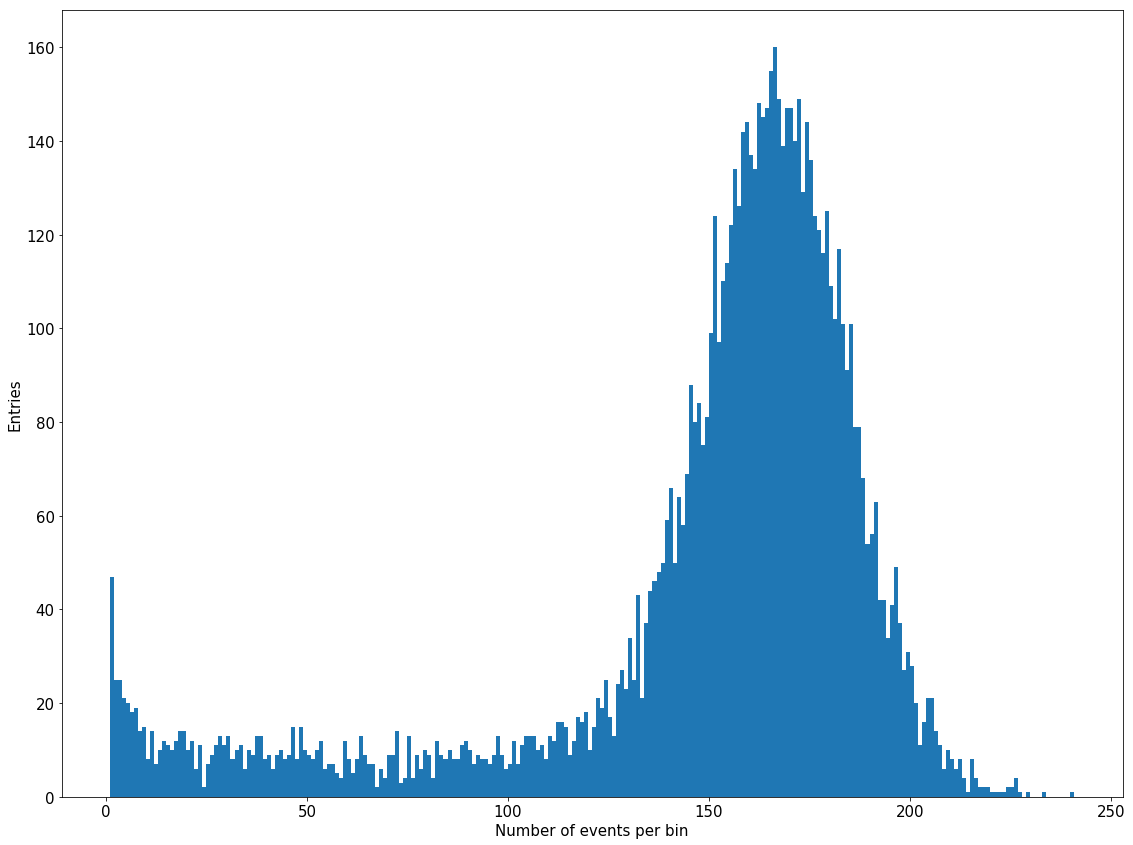

In [15]:
Nevt_max = int(np.max(Nevt))

plt.hist(Nevt.flatten(), np.arange(Nevt_max) + 1)
labels("Number of events per bin", "Entries", f"# events per bin for {XYpitch:.1f} mm pitch")

plt.tight_layout()
save("Event_distribution_different_pitches")

### Compute charge up map

In [18]:
Tprime = T - T.min()

In [32]:
def compute_charge_up(t, e):
    x, y, u = fitf.profileX(t, e, 50, xrange=(Tprime.min(), Tprime.max()))
    plt.errorbar(x, y, u)
    fun = lambda x, a, b, c, d: c + b*np.arctan(a*(x-d))
#    f = fitf.fit(fitf.polynom, x, y, (-1, 1, 1e4))
    f = fitf.fit(fun, x, y, (1, 1e4, 0, 0))
    plt.plot(x, f.fn(x), "r-")
    return np.average(y[-3:], weights=u[-3:]) - np.average(y[:3], weights=u[:3])

1165


177.71089381293677

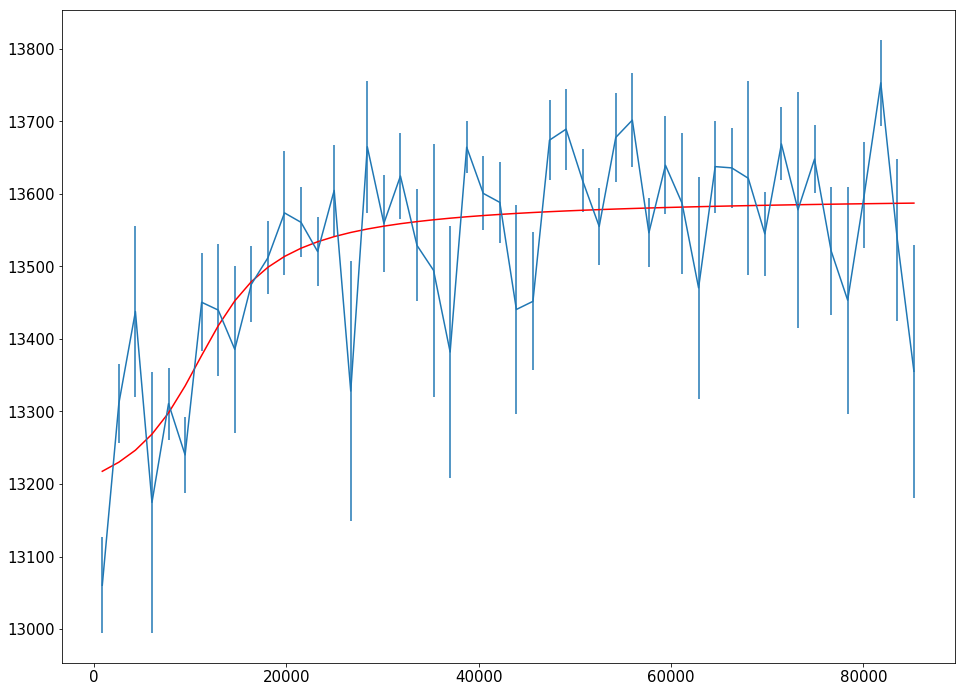

In [34]:
sel = in_range(X, -20, -10) & in_range(Y, -20, -10)
print(np.count_nonzero(sel))
compute_charge_up(Tprime[sel], E[sel])

In [ ]:
def seed_generator(*args):
    return 13e3, 1, 

In [43]:

const, slope, chi2, valid = \
fit_slices_2d_polynom(X, Y, Tprime, E,
                      XYbins, XYbins,
                      20, zrange=(Tprime.min(), Tprime.max()),
                      min_entries = 1e2)

valid = valid & (slope.value > 1e3)
chargeup = slope.value * (Tprime.max() - Tprime.min())
chargeup = np.where(valid, chargeup, 0)

/Applications/anaconda3/envs/IC3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """


In [36]:
print(np.nanmedian(Tprime) * np.nanmedian(slope))

2157517.71094


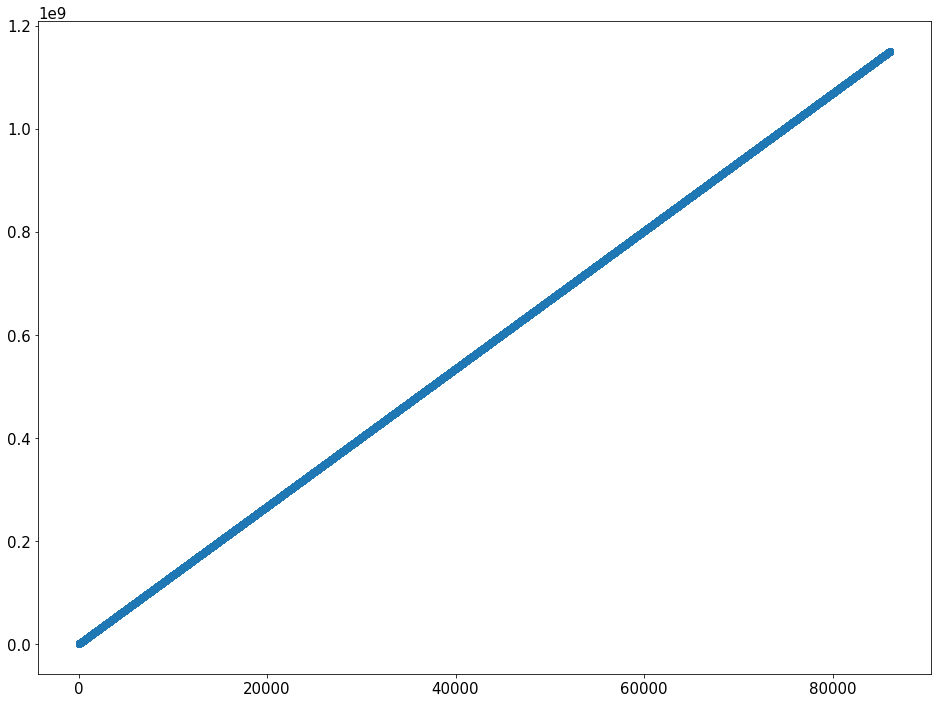

In [37]:
plt.scatter(Tprime, const.value[50, 50] + slope.value[50, 50] * Tprime);

0.0 1173297905.59


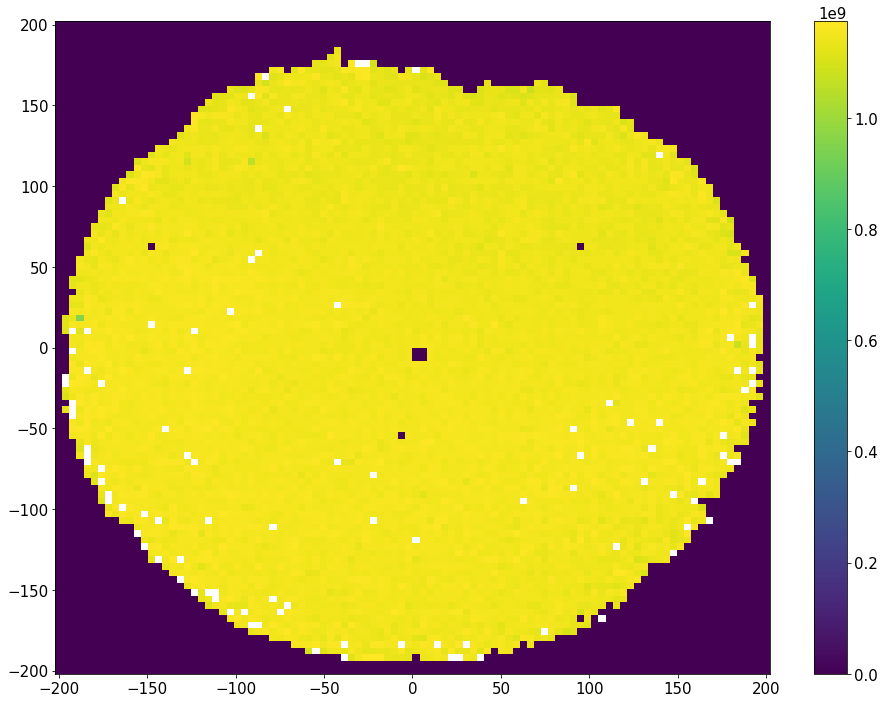

In [44]:
chargeup_min = np.nanpercentile(chargeup.flatten(),  0.1)
chargeup_max = np.nanpercentile(chargeup.flatten(), 99.0)

print(chargeup_min, chargeup_max)
display_matrix(XYcenters, XYcenters, chargeup, cmin=chargeup_min, cmax=chargeup_max);

/Applications/anaconda3/envs/IC3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6497: RuntimeWarning: invalid value encountered in greater
  h[h > cmax] = None


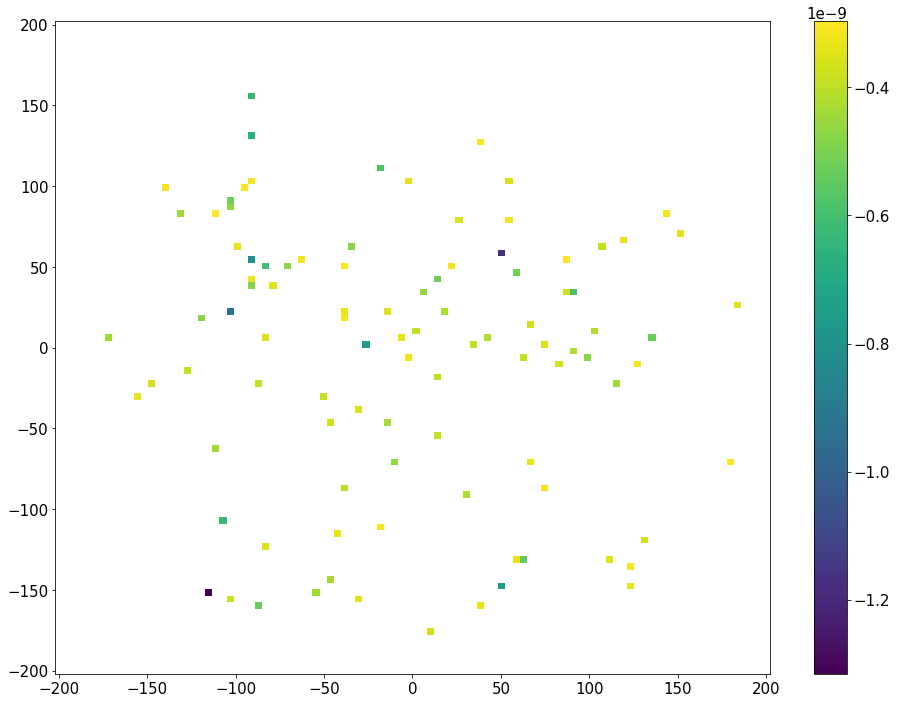

In [71]:
const_min = np.percentile(const.value.flatten(), 0.01)
const_max = np.percentile(const.value.flatten(), 0.99)

display_matrix(XYcenters, XYcenters, const.value, cmin=const_min, cmax=const_max);

In [12]:
*_, Eave_, Eaveu_ = fitf.profileXY(X, Y, E, XYnbins, XYnbins, XYrange, XYrange)
*_, Qave_, Qaveu_ = fitf.profileXY(X, Y, Q, XYnbins, XYnbins, XYrange, XYrange)

Eaveu_ = relative_errors(Eave_, Eaveu_, percentual=True)
Qaveu_ = relative_errors(Qave_, Qaveu_, percentual=True)

Eok = Eave_ > 1e3
Qok = Qave_ > 1e1

Eave   = Eave_
Eaveu  = Eaveu_

E_mean  = np.mean(Eave_ [Eok])
E_std   = np.std (Eave_ [Eok])
Eu_mean = np.mean(Eaveu_[Eok])
Eu_std  = np.std (Eaveu_[Eok])

E_min = E_mean - 3.0 *  E_std
E_max = E_mean + 2.0 *  E_std

Eu_min = Eu_mean - 1.5 * Eu_std; Eu_min = max(Eu_min, 1e-3)
Eu_max = Eu_mean + 2.0 * Eu_std

Qave  = Qave_
Qaveu = Qaveu_

Q_mean  = np.mean(Qave_ [Qok])
Q_std   = np.std (Qave_ [Qok])
Qu_mean = np.mean(Qaveu_[Qok])
Qu_std  = np.std (Qaveu_[Qok])

Q_min = Q_mean - 3.0 *  Q_std
Q_max = Q_mean + 2.0 *  Q_std

Qu_min = Qu_mean - 1.5 * Qu_std; Qu_min = max(Qu_min, 1e-3)
Qu_max = Qu_mean + 2.0 * Qu_std

### Fit example

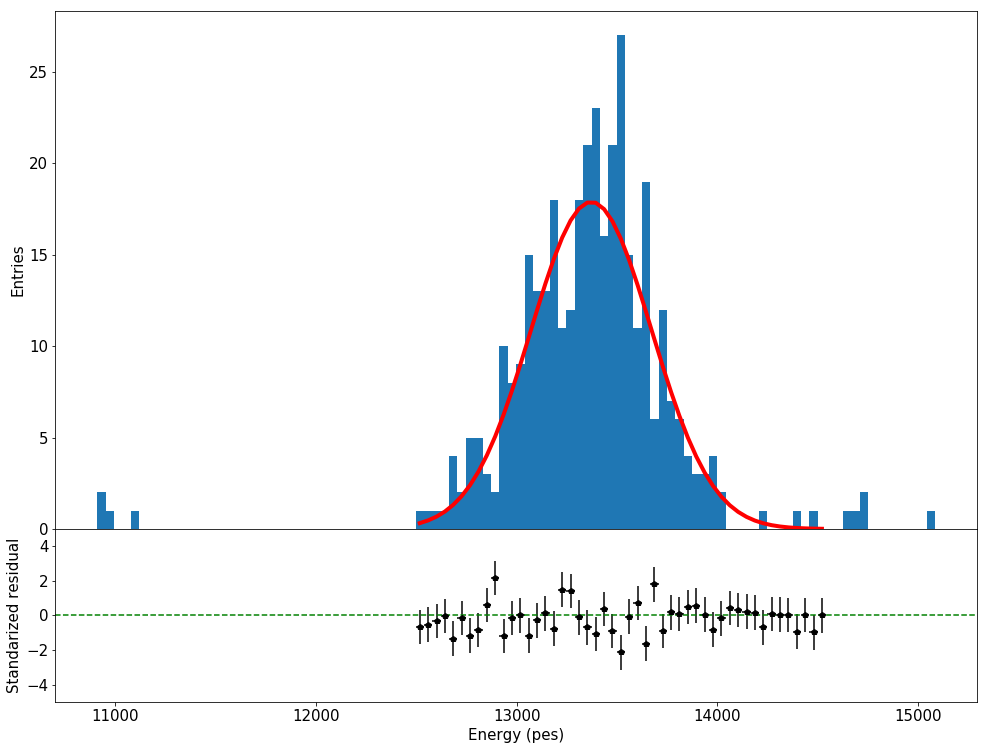

In [13]:
xlim =  15,  20
ylim = -25, -10
sel  = in_range(X, *xlim) & in_range(Y, *ylim)
e    = E[sel]

frame_data = plt.gcf().add_axes((.1, .3,
                                 .8, .6))
y, x, _   = hist(e, 100, new_figure=False)
seed      = gauss_seed(x, y)
fit_range = seed[1] - 1.5 * seed[2], seed[1] + 1.5 * seed[2]
x, y      = x[in_range(x, *fit_range)], y[in_range(x, *fit_range)]
f         = fitf.fit(fitf.gauss, x, y, seed, sigma=poisson_sigma(y))
plt.plot(x, f.fn(x), "r-", lw=4)

frame_data.set_xticklabels([])
labels("", "Entries", "Energy fit example")
lims = plt.xlim()

frame_res = plt.gcf().add_axes((.1, .1,
                                .8, .2))
plt.errorbar(x, (f.fn(x) - y) / poisson_sigma(y), 1, np.diff(x)[0] / 2, fmt="p", c="k")
plt.plot(lims, (0, 0), "g--")
plt.xlim(*lims)
plt.ylim(-5, +5)
labels("Energy (pes)", "Standarized residual")

save("Energy_fit_example")

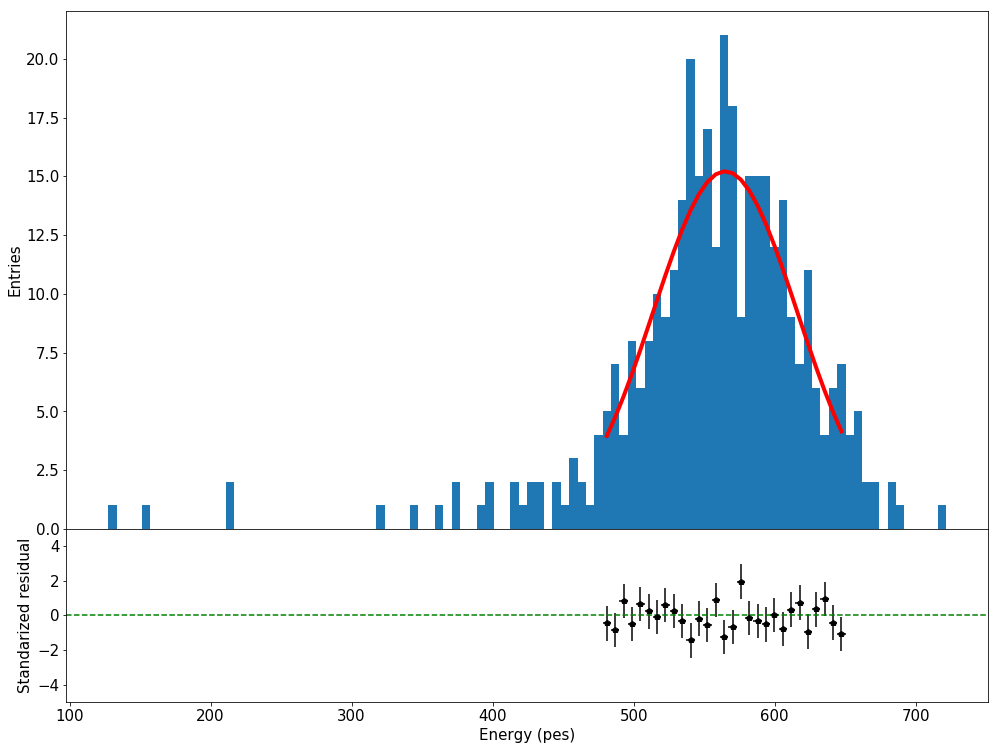

In [14]:
xlim =  15,  20
ylim = -25, -10
sel  = in_range(X, *xlim) & in_range(Y, *ylim)
q    = Q[sel]

frame_data = plt.gcf().add_axes((.1, .3,
                                 .8, .6))
y, x, _   = hist(q, 100, new_figure=False)
seed      = gauss_seed(x, y)
fit_range = seed[1] - 3 * seed[2], seed[1] + 3 * seed[2]
x, y      = x[in_range(x, *fit_range)], y[in_range(x, *fit_range)]
f         = fitf.fit(fitf.gauss, x, y, seed, sigma=poisson_sigma(y))
plt.plot(x, f.fn(x), "r-", lw=4)

frame_data.set_xticklabels([])
labels("", "Entries", "Energy fit example")
lims = plt.xlim()

frame_res = plt.gcf().add_axes((.1, .1,
                                .8, .2))
plt.errorbar(x, (f.fn(x) - y) / poisson_sigma(y), 1, np.diff(x)[0] / 2, fmt="p", c="k")
plt.plot(lims, (0, 0), "g--")
plt.xlim(*lims)
plt.ylim(-5, +5)
labels("Energy (pes)", "Standarized residual")

save("Charge_fit_example")

### Energy map display

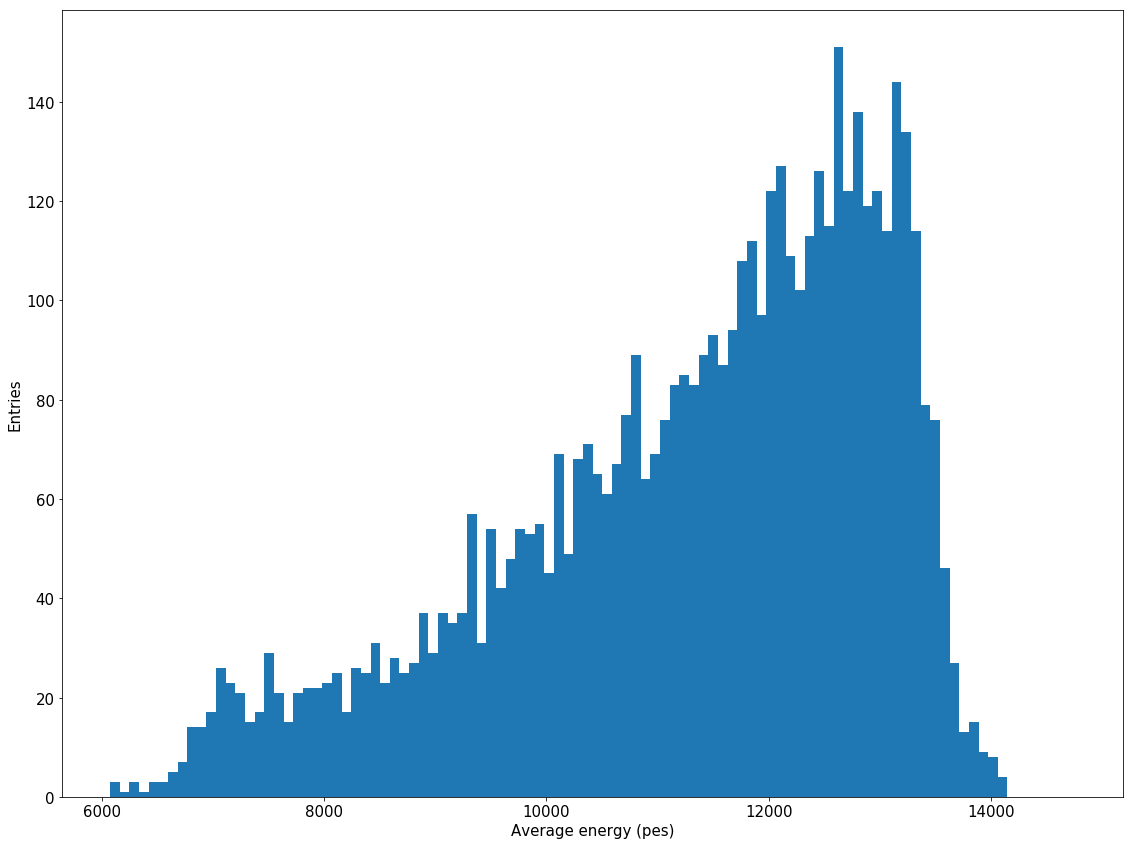

In [15]:
plt.hist(Eave.flatten(), np.linspace(E_min, E_max, 101))
labels("Average energy (pes)", "Entries", f"Average energy for {XYpitch:.1f} mm pitch")

plt.tight_layout()
save("Energy_distributions")

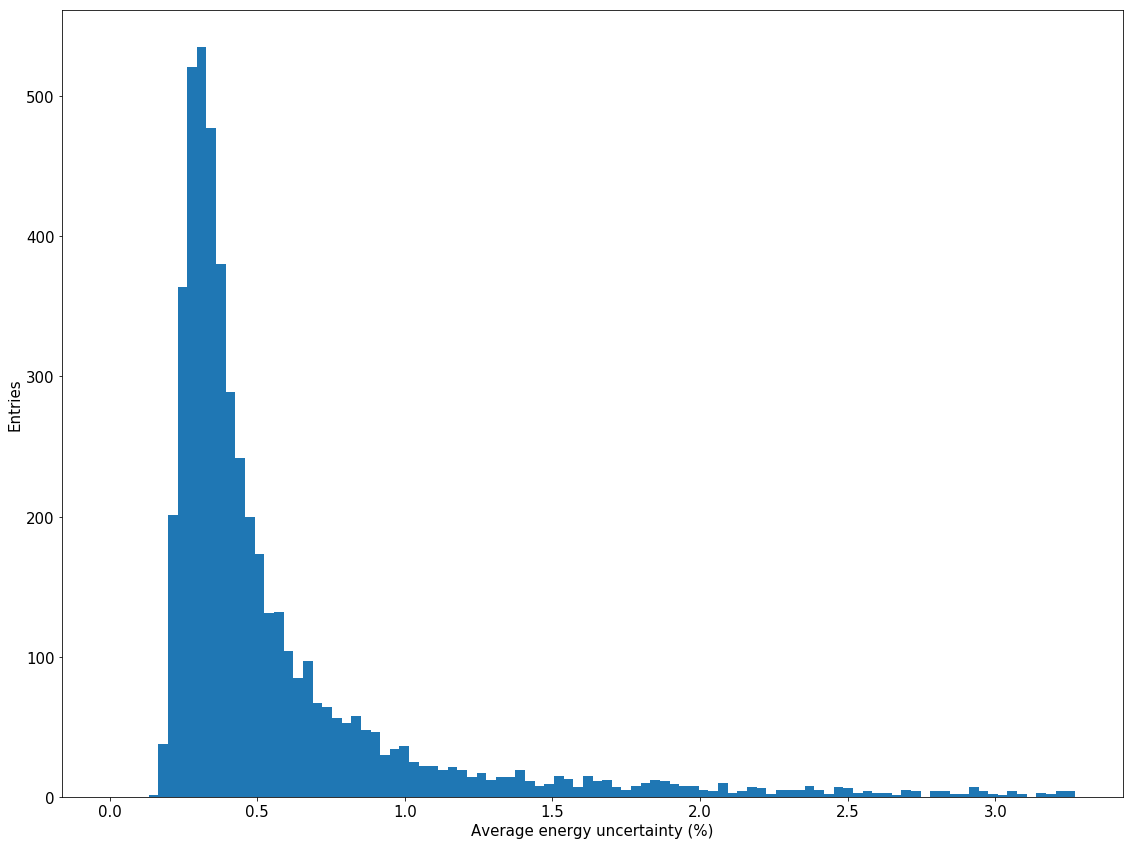

In [16]:
plt.hist(Eaveu.flatten(), np.linspace(Eu_min, Eu_max, 101))
labels("Average energy uncertainty (%)", "Entries", f"Average energy unc. for {XYpitch:.1f} mm pitch")

plt.tight_layout()
save("Energy_uncertainty_distributions")

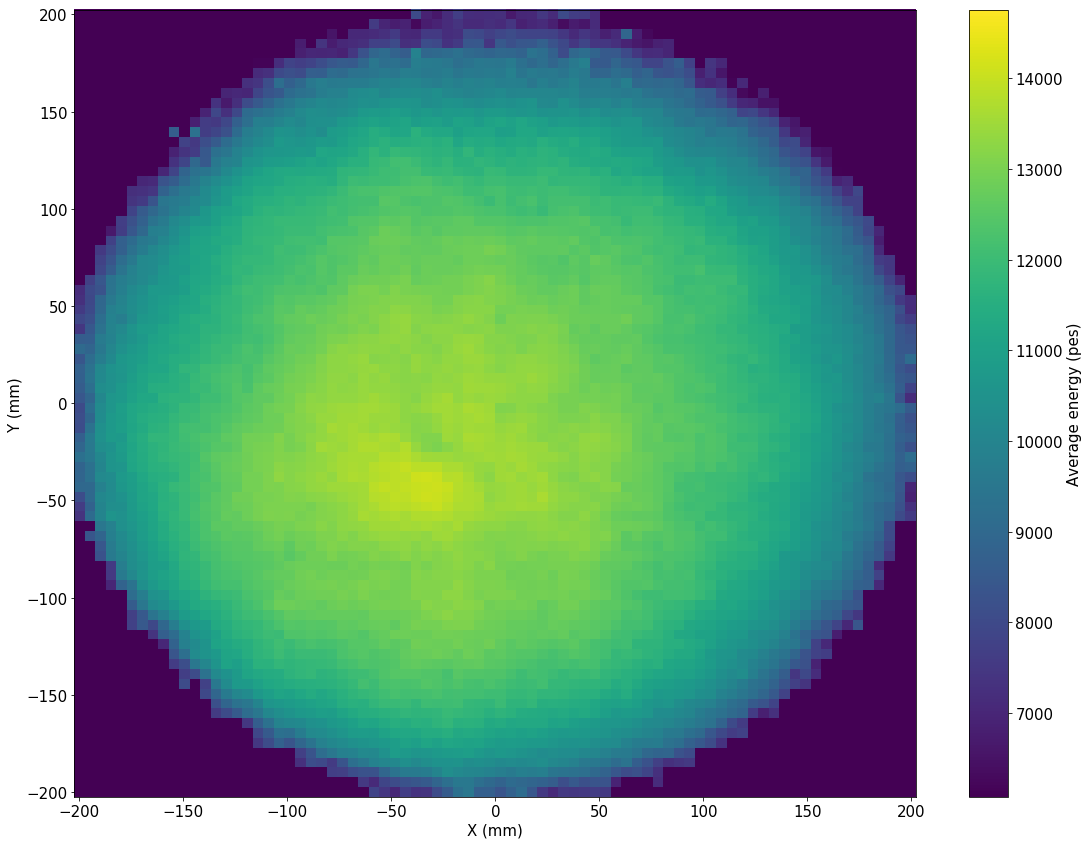

In [17]:
*_, cb = display_matrix(XYcenters, XYcenters, Eave,
                        vmin = E_min,
                        vmax = E_max,
                        cmap = default_cmap,
                        new_figure = False)
cb.set_label("Average energy (pes)")
labels("X (mm)", "Y (mm)", f"Average energy for {XYpitch:.1f} mm pitch")

plt.tight_layout()
save("Energy_maps")

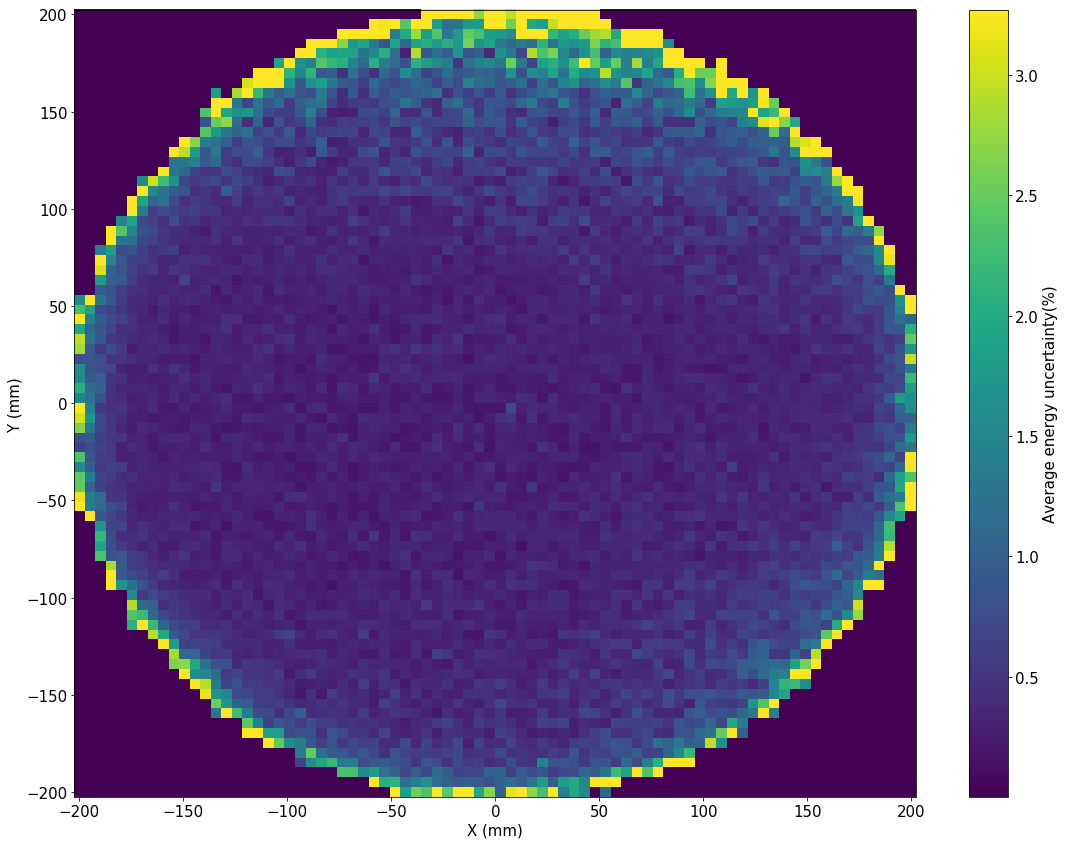

In [18]:
*_, cb = display_matrix(XYcenters, XYcenters, Eaveu,
                        vmin = Eu_min,
                        vmax = Eu_max,
                        cmap = default_cmap,
                        new_figure = False)
cb.set_label("Average energy uncertainty(%)")
labels("X (mm)", "Y (mm)", f"Average energy unc. for {XYpitch:.1f} mm pitch")

plt.tight_layout()
save("Energy_uncertainty_maps")

### Charge map display

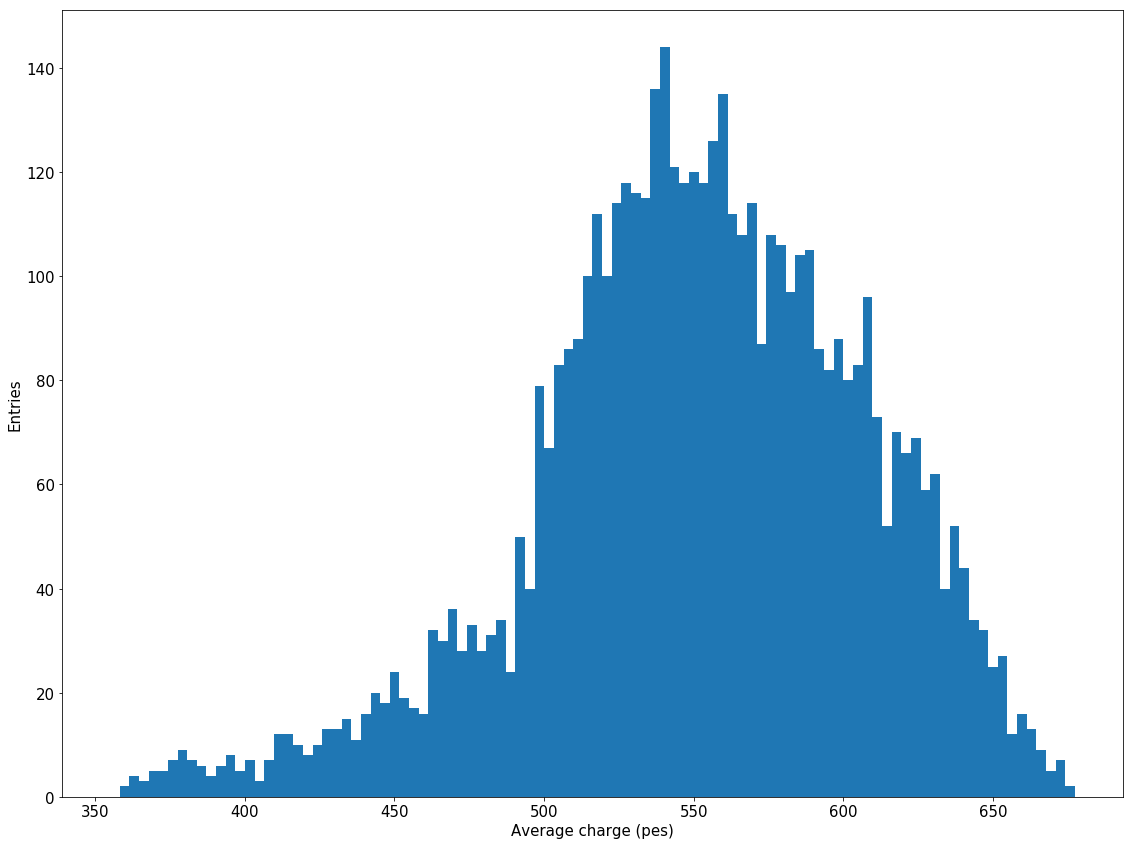

In [19]:
plt.hist(Qave.flatten(), np.linspace(Q_min, Q_max, 101))
labels("Average charge (pes)", "Entries", f"Average charge for {XYpitch:.1f} mm pitch")

plt.tight_layout()
save("Charge_distributions")

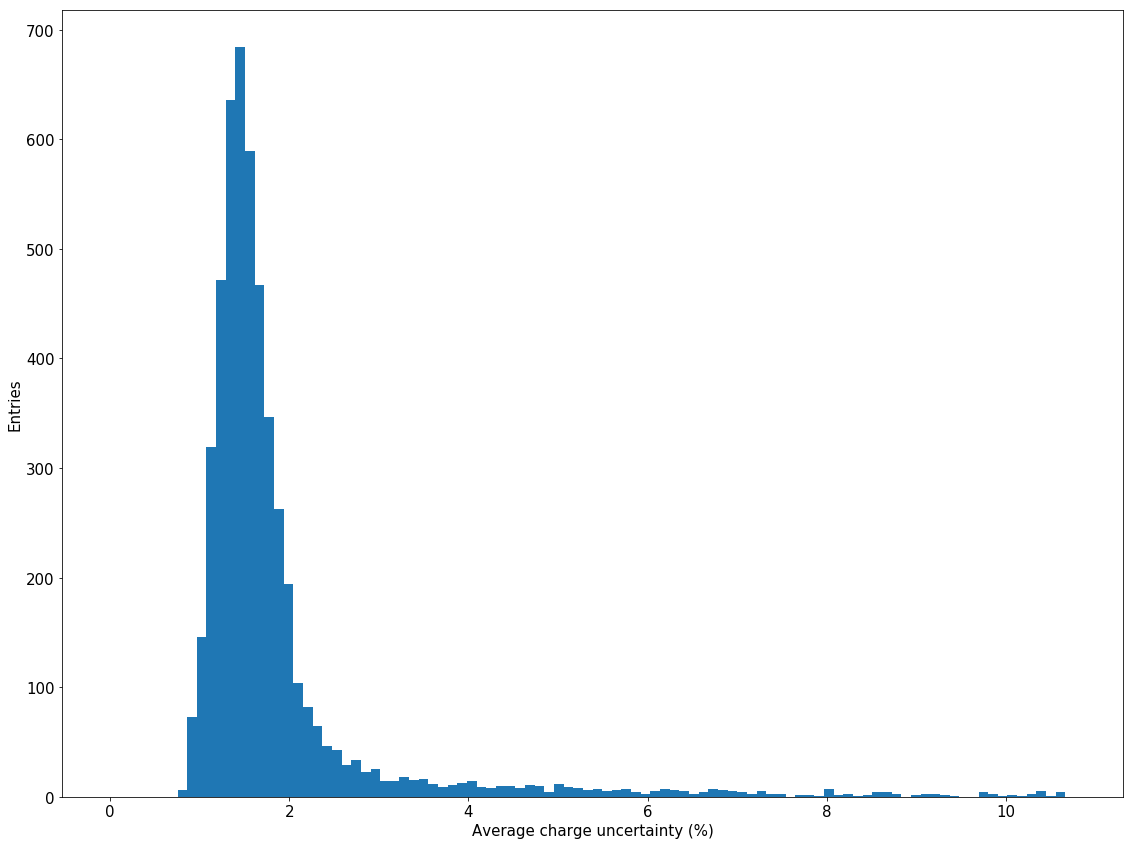

In [20]:
plt.hist(Qaveu.flatten(), np.linspace(Qu_min, Qu_max, 101))
labels("Average charge uncertainty (%)", "Entries", f"Average charge unc. for {XYpitch:.1f} mm pitch")

plt.tight_layout()
save("Charge_uncertainty_distributions")

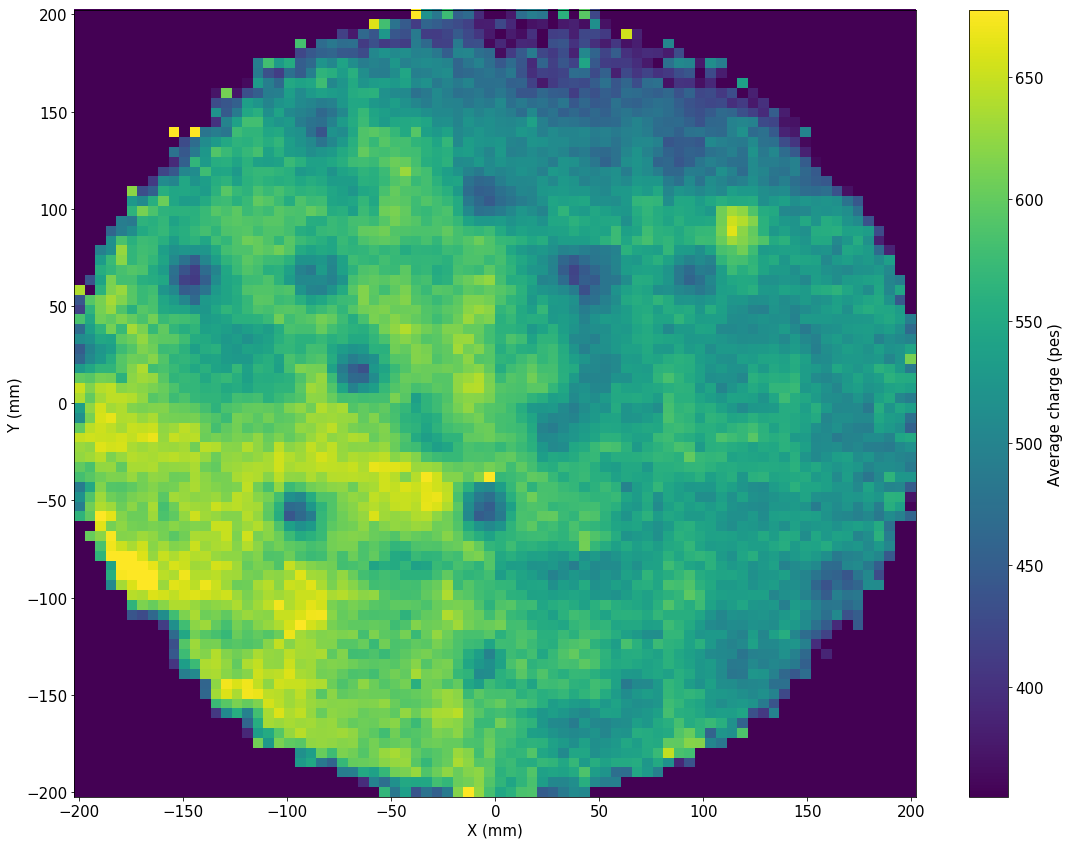

In [21]:
*_, cb = display_matrix(XYcenters, XYcenters, Qave,
                        vmin = Q_min,
                        vmax = Q_max,
                        cmap = default_cmap,
                        new_figure = False)
cb.set_label("Average charge (pes)")
labels("X (mm)", "Y (mm)", f"Average charge for {XYpitch:.1f} mm pitch")

plt.tight_layout()
save("Charge_maps")

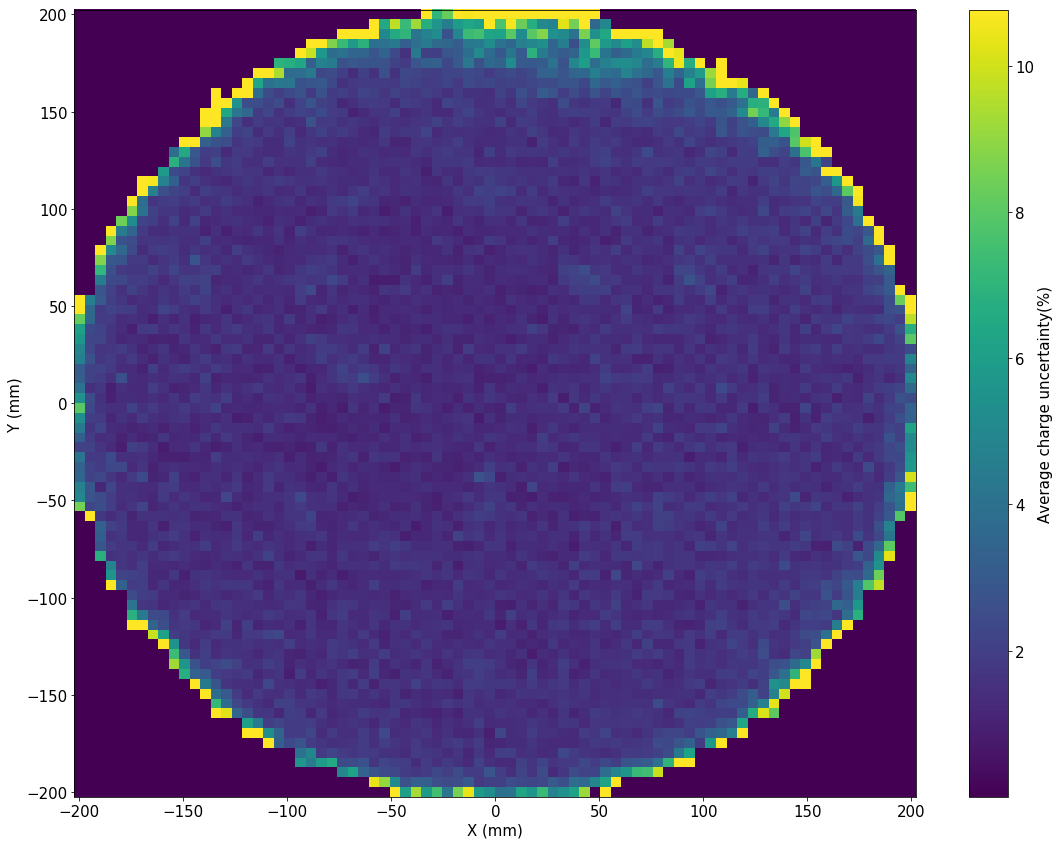

In [22]:
*_, cb = display_matrix(XYcenters, XYcenters, Qaveu,
                        vmin = Qu_min,
                        vmax = Qu_max,
                        cmap = default_cmap,
                        new_figure = False)
cb.set_label("Average charge uncertainty(%)")
labels("X (mm)", "Y (mm)", f"Average charge unc. for {XYpitch:.1f} mm pitch")

plt.tight_layout()
save("Charge_uncertainty_maps")

### Produce HDF5 output

In [23]:
class MapInfo(tb.IsDescription):
    x_nbins = tb. UInt64Col(pos=0)
    y_nbins = tb. UInt64Col(pos=1)
    x_pitch = tb.Float64Col(pos=2)
    y_pitch = tb.Float64Col(pos=3)
    x_min   = tb.Float64Col(pos=4)
    x_max   = tb.Float64Col(pos=5)
    y_min   = tb.Float64Col(pos=6)
    y_max   = tb.Float64Col(pos=7)

with tb.open_file(correction_filename, "a") as correction_file:
    map_table = correction_file.create_table(correction_file.root, "GEOMapInfo", MapInfo, "Map metadata")

    row = map_table.row
    row["x_nbins"] = XYnbins
    row["y_nbins"] = XYnbins
    row["x_pitch"] = XYpitch
    row["y_pitch"] = XYpitch
    row["x_min"  ] = XYrange[0]
    row["x_max"  ] = XYrange[1]
    row["y_min"  ] = XYrange[0]
    row["y_max"  ] = XYrange[1]
    row.append()

In [24]:
with tb.open_file(correction_filename, "r+") as output_file:
    group      = "XYcorrections"
    table_name = "GeometryE"
    if (overwrite                                      and
        group      in output_file.root                 and
        table_name in getattr(output_file.root, group)):
        output_file.remove_node(getattr(output_file.root, group), table_name)
    write = kdstio.xy_correction_writer(output_file,
                                        group      = group,
                                        table_name = table_name)
    write(XYcenters, XYcenters, Eave, Eaveu * Eave / 100, Nevt)

    table_name = "GeometryQ"
    if (overwrite                                      and
        group      in output_file.root                 and
        table_name in getattr(output_file.root, group)):
        output_file.remove_node(getattr(output_file.root, group), table_name)
    write = kdstio.xy_correction_writer(output_file,
                                        group      = group,
                                        table_name = table_name)
    write(XYcenters, XYcenters, Qave, Qaveu * Qave / 100, Nevt)